### ○, X, △ 을 그림판에 여러가지 이미지를 저장 후 CNN으로 학습을 시켜 분류를 하는 모델을 만들어보자.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [13]:
import zipfile
import os
import re

In [14]:
images_file = '/content/imagesfolder.zip'

# 압축을 해제할 디렉토리 경로
extract_to = '/content/data'

# 디렉토리가 존재하지 않으면 생성
os.makedirs(extract_to, exist_ok=True)

# 압축 파일 해제
with zipfile.ZipFile(images_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [15]:
# 데이터셋이 들어 있는 폴더 경로
data_path = './data'

# 데이터셋에 적용할 변환
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 이미지 크기 조정
    transforms.Grayscale(),       # 그레이스케일로 변환
    transforms.ToTensor()         # 텐서로 변환
])

# ImageFolder를 사용하여 데이터셋 생성
custom_dataset = ImageFolder(root=data_path, transform=transform)

In [16]:
custom_dataset

Dataset ImageFolder
    Number of datapoints: 180
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

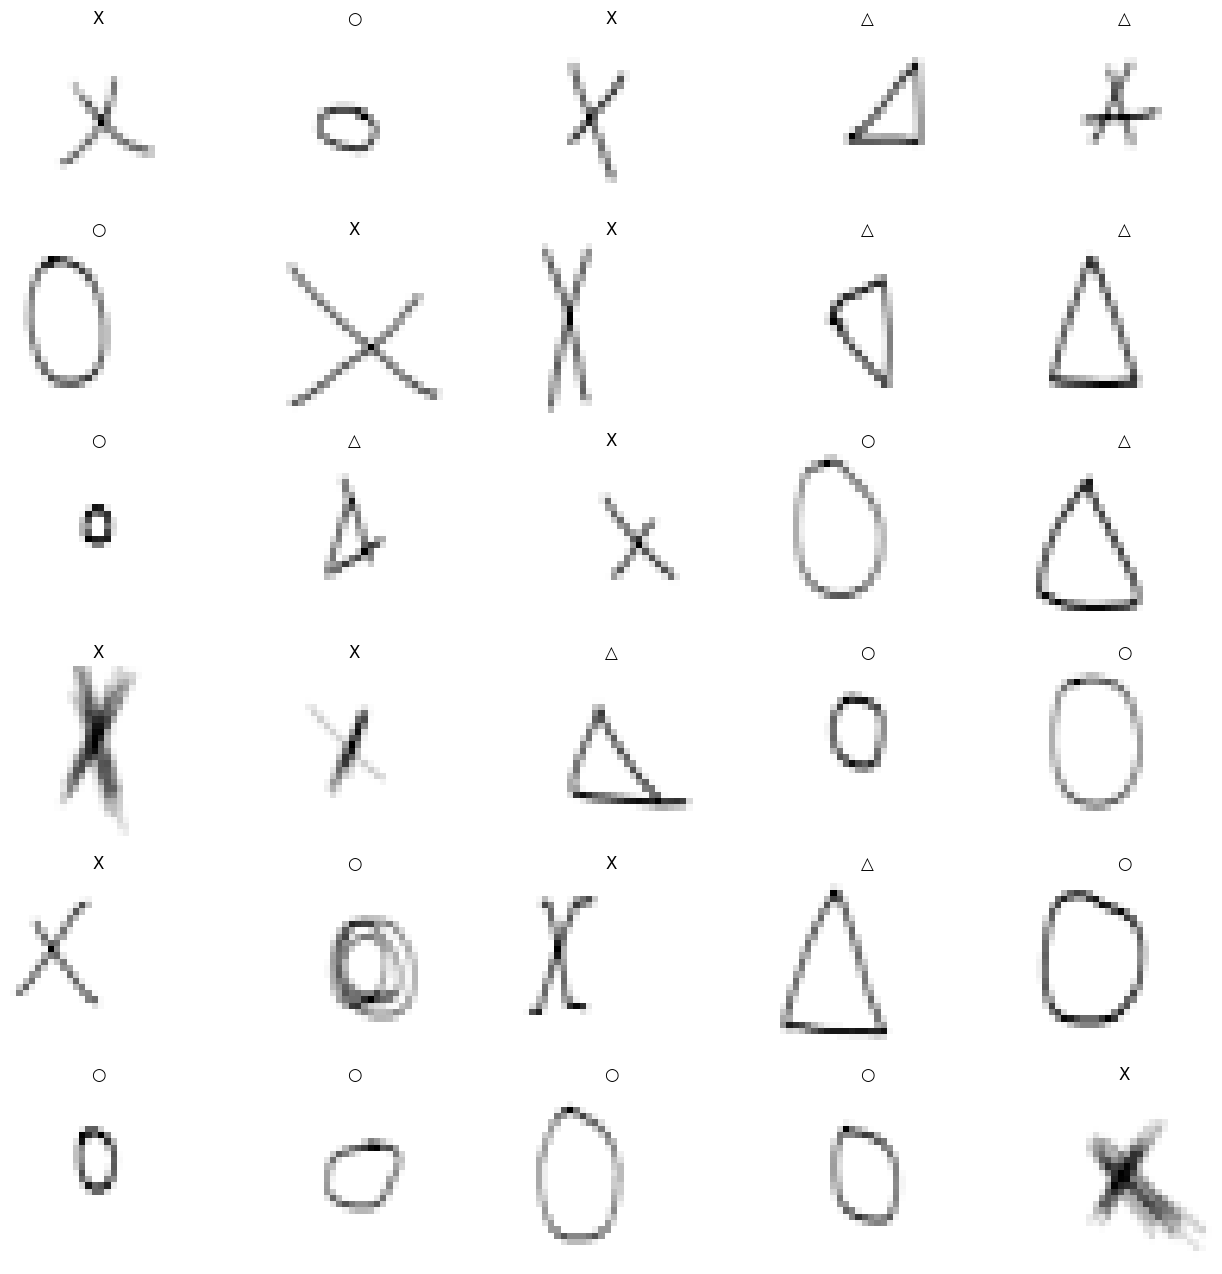

In [17]:
loader = DataLoader(
    dataset=custom_dataset,
    batch_size=30,
    shuffle=True
)
imgs, labels = next(iter(loader))
fig, axes = plt.subplots(6, 5, figsize=(16,16))
label_mapping = {
    0: "○",
    1: "△",
    2: "X",
    # 추가적으로 필요한 경우 여기에 계속 추가할 수 있습니다.
}

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label_mapping[label.item()])
    ax.axis('off')

In [18]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    # [1, 32, 14, 14]

    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    # [1, 64, 7, 7]

    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 10)
).to(device)

print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=10, bias=True)
)


In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

for epcoh in range(epochs+1):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_losses += loss.item()
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) *100
        sum_accs += acc
    avg_loss = sum_losses / len(loader)
    avg_acc = sum_accs / len(loader)
    print(f'Epcoh {epcoh:4d}/{epochs} Loss {avg_loss:.6f} Accuracy {avg_acc:.2f}%')

Epcoh    0/100 Loss 1.506402 Accuracy 27.22%
Epcoh    1/100 Loss 1.133072 Accuracy 33.89%
Epcoh    2/100 Loss 1.154518 Accuracy 29.44%
Epcoh    3/100 Loss 1.134125 Accuracy 28.33%
Epcoh    4/100 Loss 1.102214 Accuracy 31.67%
Epcoh    5/100 Loss 1.104898 Accuracy 36.11%
Epcoh    6/100 Loss 1.143602 Accuracy 26.67%
Epcoh    7/100 Loss 1.149607 Accuracy 30.00%
Epcoh    8/100 Loss 1.103343 Accuracy 35.00%
Epcoh    9/100 Loss 1.122014 Accuracy 30.56%
Epcoh   10/100 Loss 1.100910 Accuracy 38.89%
Epcoh   11/100 Loss 1.099793 Accuracy 35.56%
Epcoh   12/100 Loss 1.096244 Accuracy 34.44%
Epcoh   13/100 Loss 1.092617 Accuracy 42.22%
Epcoh   14/100 Loss 1.089477 Accuracy 38.89%
Epcoh   15/100 Loss 1.083005 Accuracy 43.89%
Epcoh   16/100 Loss 1.087811 Accuracy 41.11%
Epcoh   17/100 Loss 1.074336 Accuracy 39.44%
Epcoh   18/100 Loss 1.063444 Accuracy 46.67%
Epcoh   19/100 Loss 1.056963 Accuracy 48.89%
Epcoh   20/100 Loss 1.043777 Accuracy 52.22%
Epcoh   21/100 Loss 1.020018 Accuracy 54.44%
Epcoh   22

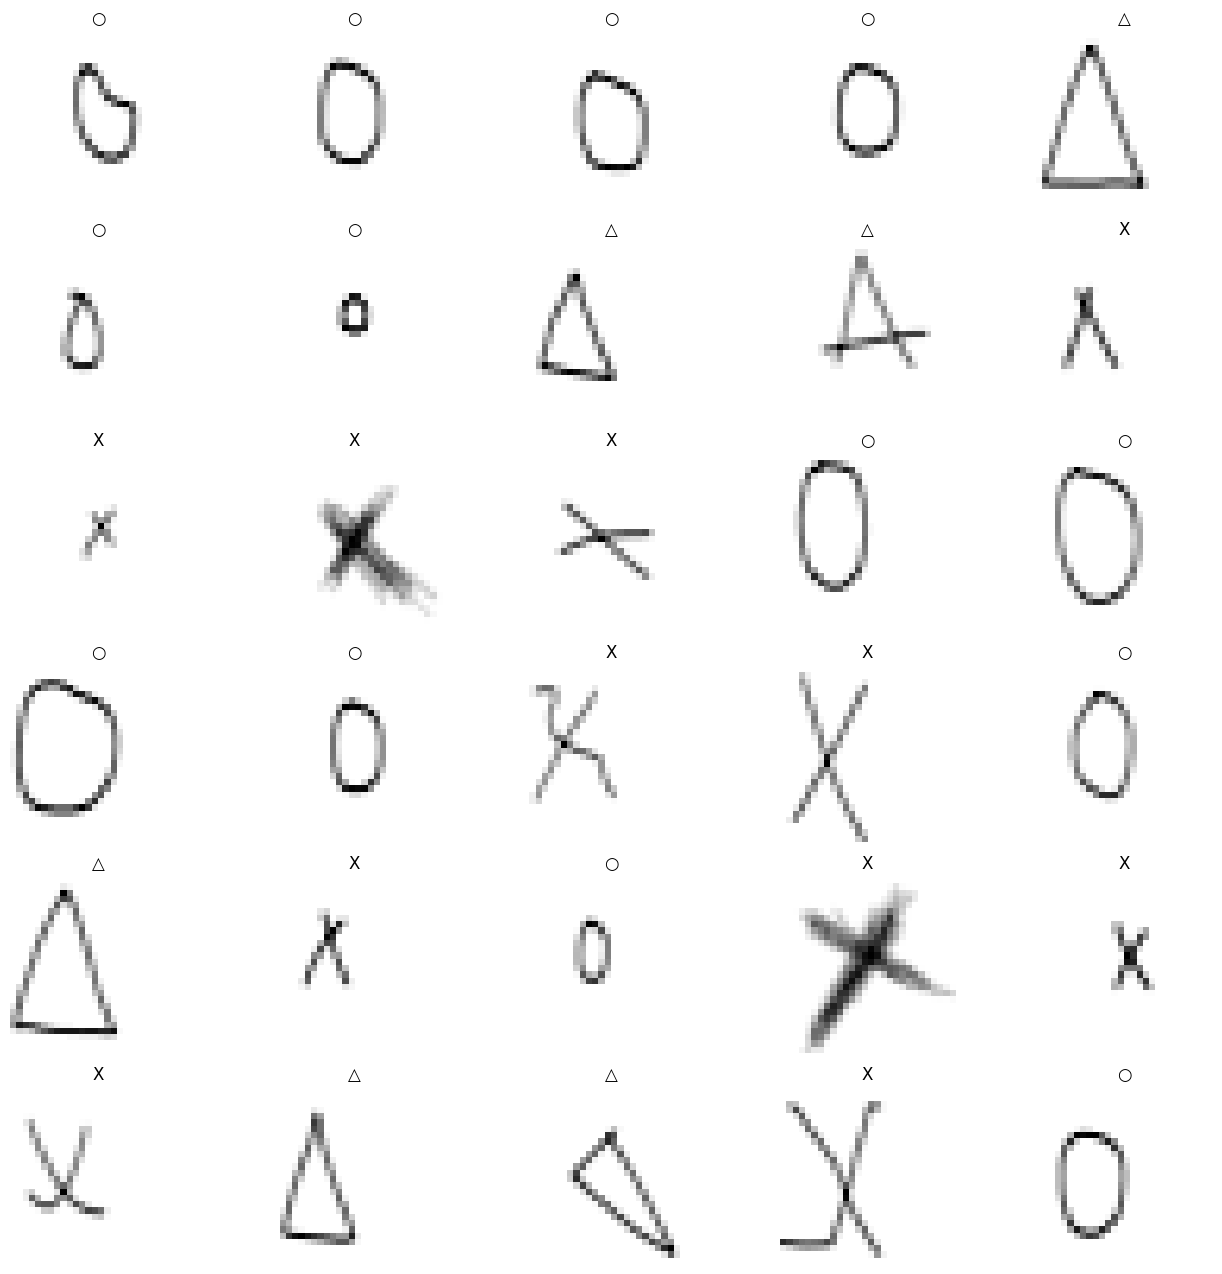

In [20]:
test_dataset = ImageFolder(root=data_path, transform=transform)
# DataLoader를 사용하여 데이터셋을 로드하고 셔플링
batch_size = 30
test_dataset = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

imgs, labels = next(iter(test_dataset))
fig, axes = plt.subplots(6, 5, figsize=(16,16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label_mapping[label.item()])
    ax.axis('off')

In [21]:
model.eval() # 모델을 테스트 모드로 전환(GD 작동 안함)

sum_accs = 0

for x_batch, y_batch in test_dataset:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) *100
    sum_accs += acc

avg_acc = sum_accs / len(test_dataset)
print(f'Accuracy {avg_acc:.2f}%')

Accuracy 95.00%
